In [1]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

1. Перших 2 байти завжди порожні тому ми їх пропускаємо зчитуючи >H тип unsigned short який займає 2 байти

2. 3-ій байт вказує на тип даних
  * 0x08: unsigned byte 
  * 0x09: signed byte 
  * 0x0B: short (2 bytes) 
  * 0x0C: int (4 bytes) 
  * 0x0D: float (4 bytes) 
  * 0x0E: double (8 bytes)
  
3. Наступний байт вказує кількість вимірів матриці

4. Далі послідовно для кожного виміру вказано його розмір як 4-байтове ціле число. Тобто, починаючи з п’ятого байту, три групи по 4 байти вказують на розмірність тривимірної матриці, а саме

In [2]:
print('Labels shape')

with gzip.open('dataset/train-labels-idx1-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>I', f.read(4)))

print('\nImages shape')
with gzip.open('dataset/train-images-idx3-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>III', f.read(12)))

Labels shape
(0, 8, 1)
(60000,)

Images shape
(0, 8, 3)
(60000, 28, 28)


In [4]:
# script for reading MNIST file format
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [11]:
raw_train = read_idx('dataset/train-images-idx3-ubyte.gz')
X_train = raw_train.reshape(60000, 28 * 28)
y_train = read_idx('dataset/train-labels-idx1-ubyte.gz')

raw_test = read_idx('dataset/t10k-images-idx3-ubyte.gz')
X_test = raw_test.reshape(10000, 28 * 28)
y_test = read_idx('dataset/t10k-labels-idx1-ubyte.gz')

In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, verbose=True).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.6min finished


In [8]:
# save classifier
from sklearn.externals import joblib
joblib.dump(clf, 'flaskr/classifiers/random-forest.pkl') 

['flaskr/classifiers/random-forest.pkl']

In [10]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    3.0s finished


0.9711

In [21]:
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 971    0    0    0    0    1    2    1    4    1]
 [   0 1124    3    2    0    2    2    0    1    1]
 [   6    0  999    6    3    0    3    8    7    0]
 [   0    0   10  975    0    5    0    9    7    4]
 [   1    0    0    0  957    0    5    0    3   16]
 [   2    0    0   11    3  860    6    3    5    2]
 [   6    3    0    0    3    4  939    0    3    0]
 [   1    3   18    2    1    0    0  991    2   10]
 [   6    0    5    8    4    5    3    3  932    8]
 [   6    5    3   10    8    3    1    4    6  963]]


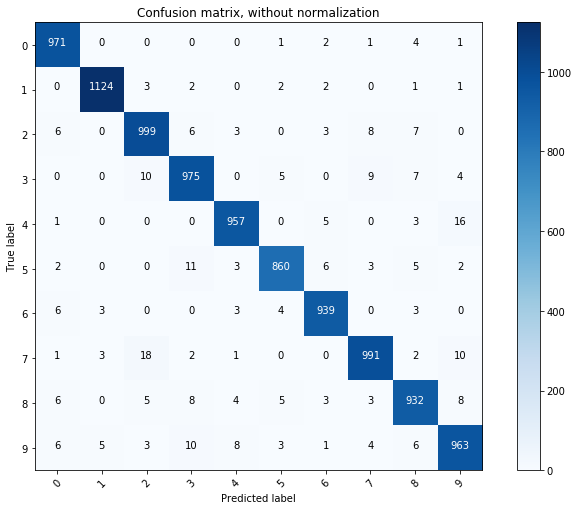

In [24]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[9.91e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.02e-03 2.04e-03 1.02e-03
  4.08e-03 1.02e-03]
 [0.00e+00 9.90e-01 2.64e-03 1.76e-03 0.00e+00 1.76e-03 1.76e-03 0.00e+00
  8.81e-04 8.81e-04]
 [5.81e-03 0.00e+00 9.68e-01 5.81e-03 2.91e-03 0.00e+00 2.91e-03 7.75e-03
  6.78e-03 0.00e+00]
 [0.00e+00 0.00e+00 9.90e-03 9.65e-01 0.00e+00 4.95e-03 0.00e+00 8.91e-03
  6.93e-03 3.96e-03]
 [1.02e-03 0.00e+00 0.00e+00 0.00e+00 9.75e-01 0.00e+00 5.09e-03 0.00e+00
  3.05e-03 1.63e-02]
 [2.24e-03 0.00e+00 0.00e+00 1.23e-02 3.36e-03 9.64e-01 6.73e-03 3.36e-03
  5.61e-03 2.24e-03]
 [6.26e-03 3.13e-03 0.00e+00 0.00e+00 3.13e-03 4.18e-03 9.80e-01 0.00e+00
  3.13e-03 0.00e+00]
 [9.73e-04 2.92e-03 1.75e-02 1.95e-03 9.73e-04 0.00e+00 0.00e+00 9.64e-01
  1.95e-03 9.73e-03]
 [6.16e-03 0.00e+00 5.13e-03 8.21e-03 4.11e-03 5.13e-03 3.08e-03 3.08e-03
  9.57e-01 8.21e-03]
 [5.95e-03 4.96e-03 2.97e-03 9.91e-03 7.93e-03 2.97e-03 9.91e-04 3.96e-03
  5.95e-03 9.54e-01]]


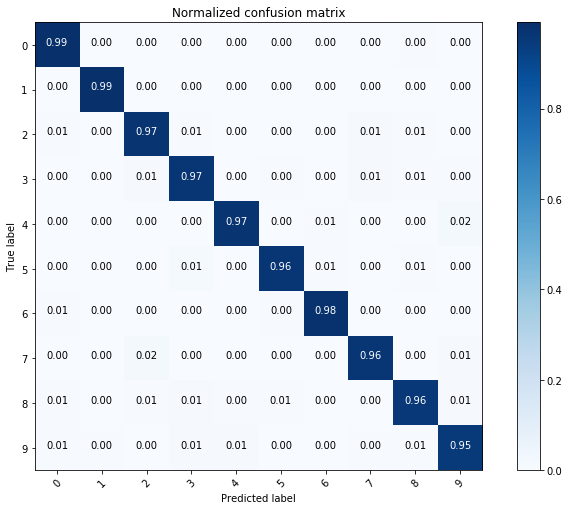

In [25]:
# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize=True,
                      title='Normalized confusion matrix')

In [26]:
plt.show()

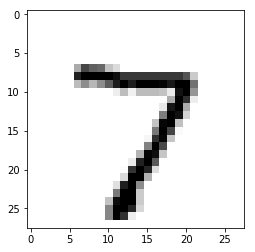

In [32]:
plt.imshow(X_test[0].reshape(28, 28), cmap="binary")